## Notes

- Left multiplying by a permutation matrix permutes the rows, right multiplying permutes the columns.

## Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import torch
from scipy.spatial.distance import cdist
import numpy as np
import time
from tqdm import tqdm
import pygmtools as pygm
import functools

pygm.set_backend("numpy")


def time_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function {func.__name__} took {end_time - start_time} seconds to run.")
        return result

    return wrapper

/home/donato/miniconda3/envs/ccmm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Input

In [2]:
@time_decorator
def create_permuted_matrices(n, d, plot=False):
    Wa = torch.rand(n * d).reshape(n, d)

    gt_perm_ba_indices = torch.randperm(n)
    P_BA_gt = torch.eye(n)[gt_perm_ba_indices]

    if plot:
        fig = px.imshow(P_BA_gt)
        fig.show()

    Wb = P_BA_gt @ Wa

    P_AB_gt = P_BA_gt.T

    assert torch.all(P_AB_gt @ Wb == Wa)

    return Wa, Wb, P_AB_gt


Wa, Wb, P_AB_gt = create_permuted_matrices(n=32, d=128)

Function create_permuted_matrices took 0.05284261703491211 seconds to run.


## Affinity matrix

In [3]:
@time_decorator
def build_affinity_matrix_inefficient(Wa, Wb):
    Wa = torch.tensor(Wa)
    Wb = torch.tensor(Wb)

    num_neurons = len(Wa)
    num_matchings = num_neurons**2

    S = torch.zeros((num_matchings, num_matchings))

    for xi in tqdm(range(num_neurons)):
        p_xi = Wa[xi, :]
        for yi in range(num_neurons):
            p_yi = Wb[yi, :]
            for xj in range(num_neurons):
                p_xj = Wa[xj, :]
                dx = torch.norm(p_xi - p_xj, p=2)
                for yj in range(num_neurons):
                    p_yj = Wb[yj, :]
                    dy = torch.norm(p_yi - p_yj, p=2)
                    S[xi * num_neurons + yi, xj * num_neurons + yj] = torch.exp(-torch.abs(dx - dy) / 1e-2)

    return S.numpy()

In [4]:
affinity = build_affinity_matrix_inefficient(Wa, Wb)

/tmp/ipykernel_8692/86101182.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Wa = torch.tensor(Wa)
/tmp/ipykernel_8692/86101182.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Wb = torch.tensor(Wb)
100%|██████████| 32/32 [00:15<00:00,  2.07it/s]

Function build_affinity_matrix_inefficient took 15.456895351409912 seconds to run.


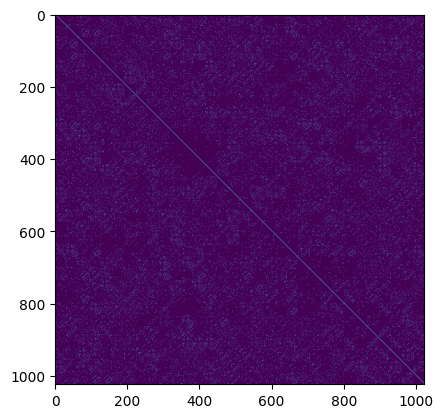

In [5]:
assert np.all(affinity == affinity.T)
fig = plt.imshow(affinity)

plt.show()

In [6]:
from backports.strenum import StrEnum
from enum import auto


class DiagContent(StrEnum):
    """Enum for diagonal content of affinity matrix"""

    ONES = auto()
    SIMILARITIES = auto()


@time_decorator
def build_affinity_matrix_vectorized(Wa, Wb, diag: DiagContent):
    Wa = torch.tensor(Wa)
    Wb = torch.tensor(Wb)

    num_neurons = Wa.size(0)
    num_matchings = num_neurons**2

    # Compute all pairwise Euclidean distances for Wa and Wb
    Wa_distances = torch.cdist(Wa, Wa, p=2)
    Wb_distances = torch.cdist(Wb, Wb, p=2)

    # Prepare the distance matrices for broadcasting
    Wa_distances = Wa_distances.view(num_neurons, 1, num_neurons, 1).expand(-1, num_neurons, -1, num_neurons)
    Wb_distances = Wb_distances.view(1, num_neurons, 1, num_neurons).expand(num_neurons, -1, num_neurons, -1)

    S = torch.exp(-torch.abs(Wa_distances - Wb_distances) / 1e-2)

    S = S.reshape(num_matchings, num_matchings)

    if diag == DiagContent.ONES:
        diag_matrix = torch.eye(num_matchings)

    elif diag == DiagContent.SIMILARITIES:
        Wa_Wb_distances = torch.cdist(Wa, Wb, p=2)
        Wa_Wb_sim = torch.exp(-torch.abs(Wa_Wb_distances) / 1e-2)

        Wa_Wb_sim = Wa_Wb_sim.reshape(num_matchings, 1)

        diag_matrix = torch.diag(Wa_Wb_sim.squeeze())

    mask = torch.eye(num_matchings, dtype=torch.bool)
    S[mask] = 0

    S = S + diag_matrix

    return S.numpy()

In [7]:
diag_content = DiagContent.ONES
affinity_vectorized = build_affinity_matrix_vectorized(Wa, Wb, diag=diag_content)

Function build_affinity_matrix_vectorized took 0.012940168380737305 seconds to run.


/tmp/ipykernel_8692/2491473191.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Wa = torch.tensor(Wa)
/tmp/ipykernel_8692/2491473191.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Wb = torch.tensor(Wb)


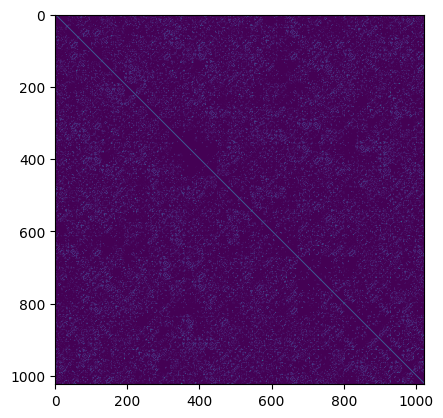

In [8]:
fig = plt.imshow(affinity_vectorized)

plt.show()

assert np.all(np.abs(affinity_vectorized.T - affinity_vectorized) < 5e-3)

In [9]:
if diag_content == DiagContent.ONES:
    assert np.all(np.abs(np.diag(affinity_vectorized) - 1) < 5e-3)

## Matching

In [10]:
@time_decorator
def get_principal_eigenvector(M):
    num_neurons = torch.sqrt(torch.tensor(M.size(0))).int()

    values, vectors = torch.linalg.eigh(M)
    principal_eigenvector = vectors[:, torch.argmax(values)]

    principal_eigenvector = principal_eigenvector.reshape(num_neurons, num_neurons)
    principal_eigenvector = torch.abs(principal_eigenvector)

    return principal_eigenvector

In [11]:
principal_eigenvector = get_principal_eigenvector(torch.tensor(affinity_vectorized))

Function get_principal_eigenvector took 0.0571436882019043 seconds to run.


In [12]:
dist_aa = torch.cdist(Wa, Wa, p=2)
dist_bb = torch.cdist(Wb, Wb, p=2)

In [13]:
num_neurons = len(Wa)

dist_aa_batched = np.expand_dims(dist_aa, axis=0)
dist_bb_batched = np.expand_dims(dist_bb, axis=0)
num_neurons_batched = np.expand_dims(num_neurons, axis=0)

conn1, edge1, ne1 = pygm.utils.dense_to_sparse(dist_aa_batched)
conn2, edge2, ne2 = pygm.utils.dense_to_sparse(dist_bb_batched)

gaussian_aff = functools.partial(pygm.utils.gaussian_aff_fn, sigma=1)
inner_prod_aff_fn = pygm.utils.inner_prod_aff_fn

K = pygm.utils.build_aff_mat(
    node_feat1=None,
    edge_feat1=edge1,
    connectivity1=conn1,
    node_feat2=None,
    edge_feat2=edge2,
    connectivity2=conn2,
    n1=num_neurons_batched,
    ne1=None,
    n2=num_neurons_batched,
    ne2=None,
    edge_aff_fn=inner_prod_aff_fn,
)

In [14]:
X = pygm.sm(K, num_neurons_batched, num_neurons_batched).squeeze()

X = pygm.hungarian(X)

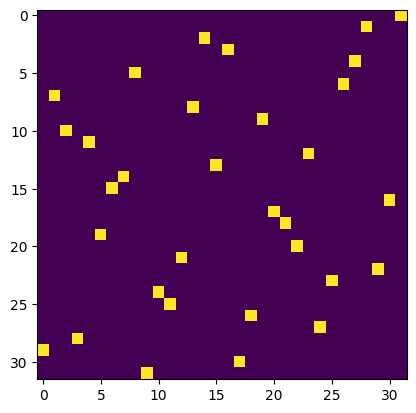

In [15]:
fig = plt.imshow(X)
plt.show()

In [16]:
matching_accuracy = (P_AB_gt * X).sum() / num_neurons
matching_accuracy

tensor(0.7812)

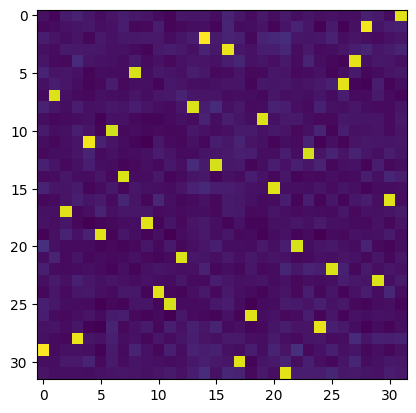

In [17]:
fig = plt.imshow(principal_eigenvector)
plt.show()

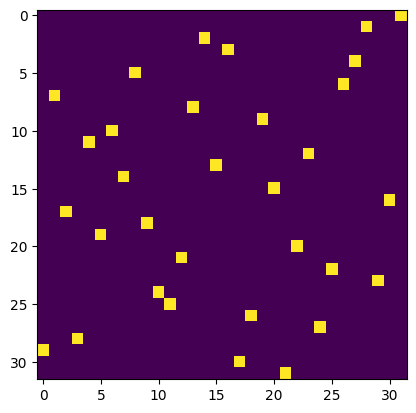

In [18]:
fig = plt.imshow(P_AB_gt)
plt.show()

In [19]:
from torch import Tensor


@time_decorator
def extract_matching_leordeanu(principal_eigenvector: Tensor):
    """
    principal_eigenvector: shape (num_neurons, num_neurons)
    """

    num_neurons = principal_eigenvector.shape[0]

    # Initialize the solution vector
    x = torch.zeros((num_neurons, num_neurons)).type_as(principal_eigenvector).long()

    # Initialize masks for rows and columns
    row_mask = torch.ones(num_neurons, dtype=torch.bool)
    col_mask = torch.ones(num_neurons, dtype=torch.bool)

    while True:
        # Apply masks to principal eigenvector
        masked_principal_eigenvector = principal_eigenvector.clone()
        masked_principal_eigenvector[~row_mask, :] = 0
        masked_principal_eigenvector[:, ~col_mask] = 0

        # Find the maximum value and its index
        flat_index = masked_principal_eigenvector.argmax()

        i, j = np.unravel_index(flat_index.item(), (num_neurons, num_neurons))

        assignment_value = masked_principal_eigenvector[(i, j)]
        if assignment_value == 0:
            break

        # Update the solution vector
        x[i, j] = 1

        # Update the masks to exclude row i and column j
        row_mask[i] = False
        col_mask[j] = False

    return x

In [20]:
P_AB_leordeanu = extract_matching_leordeanu(principal_eigenvector)

Function extract_matching_leordeanu took 0.00397038459777832 seconds to run.


In [21]:
from scipy.optimize import linear_sum_assignment
import scipy


def extract_matching_lap(principal_eigenvector):
    num_neurons = principal_eigenvector.shape[0]

    principal_eigenvector = principal_eigenvector.cpu().numpy()

    row_ind, col_ind = linear_sum_assignment(principal_eigenvector.max() - principal_eigenvector)
    P_AB = scipy.sparse.coo_matrix(
        (np.ones(num_neurons), (row_ind, col_ind)), shape=(num_neurons, num_neurons)
    ).toarray()

    return torch.tensor(P_AB)

In [22]:
P_AB_lap = extract_matching_lap(principal_eigenvector)

In [23]:
assert torch.all(P_AB_leordeanu == P_AB_lap)

In [24]:
assert torch.all(P_AB_leordeanu == P_AB_gt)

In [25]:
class EigenvectorPostprocess(StrEnum):
    LEORDEANU = auto()
    LAP = auto()


def compare_matching_algorithms(num_neurons, dim, eigenvec_postprocess: EigenvectorPostprocess):
    Wa, Wb, P_AB_gt = create_permuted_matrices(num_neurons, dim)

    affinity = build_affinity_matrix_vectorized(Wa, Wb, diag=DiagContent.ONES)
    affinity = torch.tensor(affinity).cuda()

    principal_eigenvector = get_principal_eigenvector(affinity)

    if eigenvec_postprocess == EigenvectorPostprocess.LEORDEANU:
        P_AB = extract_matching_leordeanu(principal_eigenvector)
    elif eigenvec_postprocess == EigenvectorPostprocess.LAP:
        P_AB = extract_matching_lap(principal_eigenvector)

    matching_accuracy = (P_AB_gt.cuda() * P_AB.cuda()).sum() / num_neurons

    assert torch.all(P_AB.cpu().float() @ Wb.cpu() == Wa.cpu())

    return matching_accuracy

In [26]:
all_accuracies = []
for i in tqdm(range(20)):
    acc = compare_matching_algorithms(128, 256, EigenvectorPostprocess.LEORDEANU)
    all_accuracies.append(acc)

  0%|          | 0/20 [00:00<?, ?it/s]

Function create_permuted_matrices took 0.009721040725708008 seconds to run.


/tmp/ipykernel_8692/2491473191.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Wa = torch.tensor(Wa)
/tmp/ipykernel_8692/2491473191.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Wb = torch.tensor(Wb)


Function build_affinity_matrix_vectorized took 1.011322259902954 seconds to run.


  5%|▌         | 1/20 [00:08<02:34,  8.11s/it]

Function get_principal_eigenvector took 6.445803642272949 seconds to run.
Function extract_matching_leordeanu took 0.03240013122558594 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0006546974182128906 seconds to run.
Function build_affinity_matrix_vectorized took 0.9763176441192627 seconds to run.


 10%|█         | 2/20 [00:15<02:21,  7.88s/it]

Function get_principal_eigenvector took 6.305072784423828 seconds to run.
Function extract_matching_leordeanu took 0.014417648315429688 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0006668567657470703 seconds to run.
Function build_affinity_matrix_vectorized took 0.999821662902832 seconds to run.


 15%|█▌        | 3/20 [00:23<02:13,  7.83s/it]

Function get_principal_eigenvector took 6.31201434135437 seconds to run.
Function extract_matching_leordeanu took 0.01253199577331543 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0004067420959472656 seconds to run.
Function build_affinity_matrix_vectorized took 0.9754528999328613 seconds to run.


 20%|██        | 4/20 [00:31<02:04,  7.78s/it]

Function get_principal_eigenvector took 6.3179707527160645 seconds to run.
Function extract_matching_leordeanu took 0.013118743896484375 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0003402233123779297 seconds to run.
Function build_affinity_matrix_vectorized took 0.9872357845306396 seconds to run.


 25%|██▌       | 5/20 [00:39<01:56,  7.76s/it]

Function get_principal_eigenvector took 6.309079885482788 seconds to run.
Function extract_matching_leordeanu took 0.021168947219848633 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0006723403930664062 seconds to run.
Function build_affinity_matrix_vectorized took 0.9387102127075195 seconds to run.


 30%|███       | 6/20 [00:46<01:47,  7.71s/it]

Function get_principal_eigenvector took 6.305808067321777 seconds to run.
Function extract_matching_leordeanu took 0.013576745986938477 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0004980564117431641 seconds to run.
Function build_affinity_matrix_vectorized took 0.9218275547027588 seconds to run.


 35%|███▌      | 7/20 [00:54<01:39,  7.65s/it]

Function get_principal_eigenvector took 6.3057239055633545 seconds to run.
Function extract_matching_leordeanu took 0.011492252349853516 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.00034117698669433594 seconds to run.
Function build_affinity_matrix_vectorized took 0.8662350177764893 seconds to run.


 40%|████      | 8/20 [01:01<01:31,  7.63s/it]

Function get_principal_eigenvector took 6.304646253585815 seconds to run.
Function extract_matching_leordeanu took 0.011506319046020508 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.000316619873046875 seconds to run.
Function build_affinity_matrix_vectorized took 1.1748230457305908 seconds to run.


 45%|████▌     | 9/20 [01:09<01:24,  7.69s/it]

Function get_principal_eigenvector took 6.301732778549194 seconds to run.
Function extract_matching_leordeanu took 0.011277198791503906 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0002694129943847656 seconds to run.
Function build_affinity_matrix_vectorized took 0.9035849571228027 seconds to run.


 50%|█████     | 10/20 [01:17<01:16,  7.64s/it]

Function get_principal_eigenvector took 6.308148622512817 seconds to run.
Function extract_matching_leordeanu took 0.011579275131225586 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0004131793975830078 seconds to run.
Function build_affinity_matrix_vectorized took 0.9289782047271729 seconds to run.


 55%|█████▌    | 11/20 [01:24<01:08,  7.61s/it]

Function get_principal_eigenvector took 6.298798561096191 seconds to run.
Function extract_matching_leordeanu took 0.011731147766113281 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0004146099090576172 seconds to run.
Function build_affinity_matrix_vectorized took 0.9273314476013184 seconds to run.


 60%|██████    | 12/20 [01:32<01:00,  7.62s/it]

Function get_principal_eigenvector took 6.308704614639282 seconds to run.
Function extract_matching_leordeanu took 0.014169692993164062 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.00042366981506347656 seconds to run.
Function build_affinity_matrix_vectorized took 0.9209229946136475 seconds to run.


 65%|██████▌   | 13/20 [01:39<00:53,  7.62s/it]

Function get_principal_eigenvector took 6.303584337234497 seconds to run.
Function extract_matching_leordeanu took 0.011721611022949219 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0002942085266113281 seconds to run.
Function build_affinity_matrix_vectorized took 0.925408124923706 seconds to run.


 70%|███████   | 14/20 [01:47<00:45,  7.62s/it]

Function get_principal_eigenvector took 6.308216571807861 seconds to run.
Function extract_matching_leordeanu took 0.012768268585205078 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0004360675811767578 seconds to run.
Function build_affinity_matrix_vectorized took 1.0237336158752441 seconds to run.


 75%|███████▌  | 15/20 [01:55<00:38,  7.67s/it]

Function get_principal_eigenvector took 6.312846660614014 seconds to run.
Function extract_matching_leordeanu took 0.012156248092651367 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0006868839263916016 seconds to run.
Function build_affinity_matrix_vectorized took 1.0090928077697754 seconds to run.


 80%|████████  | 16/20 [02:03<00:30,  7.67s/it]

Function get_principal_eigenvector took 6.307115316390991 seconds to run.
Function extract_matching_leordeanu took 0.01254582405090332 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.00035572052001953125 seconds to run.
Function build_affinity_matrix_vectorized took 0.9090080261230469 seconds to run.


 85%|████████▌ | 17/20 [02:10<00:22,  7.66s/it]

Function get_principal_eigenvector took 6.303528308868408 seconds to run.
Function extract_matching_leordeanu took 0.012761592864990234 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0012295246124267578 seconds to run.
Function build_affinity_matrix_vectorized took 1.042281150817871 seconds to run.


 90%|█████████ | 18/20 [02:18<00:15,  7.71s/it]

Function get_principal_eigenvector took 6.307882785797119 seconds to run.
Function extract_matching_leordeanu took 0.013090848922729492 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.000362396240234375 seconds to run.
Function build_affinity_matrix_vectorized took 0.9532637596130371 seconds to run.


 95%|█████████▌| 19/20 [02:26<00:07,  7.68s/it]

Function get_principal_eigenvector took 6.303085088729858 seconds to run.
Function extract_matching_leordeanu took 0.014157772064208984 seconds to run.
tensor(1., device='cuda:0')
Function create_permuted_matrices took 0.0004305839538574219 seconds to run.
Function build_affinity_matrix_vectorized took 1.219254732131958 seconds to run.


100%|██████████| 20/20 [02:34<00:00,  7.70s/it]

Function get_principal_eigenvector took 6.3104236125946045 seconds to run.
Function extract_matching_leordeanu took 0.011410236358642578 seconds to run.
tensor(1., device='cuda:0')


In [27]:
# plot all the accuracies
fig = px.histogram([acc.cpu().numpy() for acc in all_accuracies])
fig.show()